# Data Prep

In this notebook I will import and inspect the image and telemetry data taken from Donkey Sim, and organize it for modeling steps.

1. Import telemetry .csv
1. Import image data
1. Convert image data
1. Create dataframe with: 
    - steering inputs, 
    - throttle inputs
    - converted imageds
1. Save as a pickle format file for modeling

In [1]:
## Imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

from tensorflow.keras.preprocessing.image import img_to_array, load_img

2021-11-23 16:54:41.788804: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
## Directories
working_date = '11_12_2021'
working_time = '19_28_18'
data_directory = f'../data/{working_date}/{working_time}'
image_directory = f'{data_directory}/images'

## File paths
telemetry_csv = f'{data_directory}/data.csv'
input_image_dataset_file = f'{data_directory}/X_img.npy'
input_telem_dataset_file = f'{data_directory}/X_telem.pkl'
target_dataset_file = f'{data_directory}/y.npy'
fast_laps_save_file = f'../data/{working_date}/{working_time}/fast_laps.csv'

## Constants
imu_columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'vel_x', 'vel_y', 'vel_z',]
telemetry_columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 
               'gyro_z', 'vel_x', 'vel_y', 'vel_z',]
telemetry_columns = ['speed', 'pitch', 'yaw', 'roll', 'cte', 'activeNode', 'pos_x', 'pos_z']

In [3]:
## Make sure directoires exist
os.makedirs(data_directory, exist_ok=True)

## Telemetry Data

Steps:
* load simulation telemetry data csv
* cut unneeded columns
* cut incomplete last lap
* import images as numpy arrays
* create numpy array of image data arrays
* save images as input dataset X
* save steering angle and throttle data in numpy array as target dataset y


### Load CSV file as DataFrame

In [4]:
df = pd.read_csv(telemetry_csv)
df.head()

,steering_angle,throttle,speed,image,hit,time,accel_x,accel_y,accel_z,gyro_x,...,totalNodes,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,on_road,progress_on_shortest_path,lap
telemetry,0.0,0.016618,0.011107,2.62795.PNG,none,2.627950,-0.003734,0.114744,-0.343430,-0.000218,...,307,14.03957,0.563760,-68.18569,0.001070,-0.010486,0.003501,0,0,0
telemetry,0.0,0.054741,0.027851,2.678543.PNG,none,2.678543,-0.008975,0.123895,1.204847,0.000092,...,307,14.03902,0.563639,-68.18623,0.000550,-0.003081,0.027674,0,0,0
telemetry,0.0,0.094819,0.027349,2.727989.PNG,none,2.727989,-0.009076,0.117002,1.224393,0.000118,...,307,14.03850,0.563736,-68.18678,0.000188,0.001763,0.027292,0,0,0
telemetry,0.0,0.154448,0.035772,2.778249.PNG,none,2.778249,-0.008692,0.091593,0.638947,0.000203,...,307,14.03731,0.564071,-68.18811,-0.000317,0.007862,0.034896,0,0,0
telemetry,0.0,0.224829,0.054656,2.828085.PNG,none,2.828085,-0.001349,0.066614,0.582980,0.000339,...,307,14.03587,0.564352,-68.18963,-0.000429,0.010760,0.053585,0,0,0


In [5]:
## drop message label column
df.reset_index(drop=True, inplace=True)

### Rename Steering Column to Match Throttle

In [6]:
df.columns = ['steering' if col=='steering_angle' else col for col in df.columns]
df.columns

Index(['steering', 'throttle', 'speed', 'image', 'hit', 'time', 'accel_x',
       'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_w', 'pitch',
       'yaw', 'roll', 'cte', 'activeNode', 'totalNodes', 'pos_x', 'pos_y',
       'pos_z', 'vel_x', 'vel_y', 'vel_z', 'on_road',
       'progress_on_shortest_path', 'lap'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125400 entries, 0 to 125399
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   steering                   125400 non-null  float64
 1   throttle                   125400 non-null  float64
 2   speed                      125400 non-null  float64
 3   image                      125400 non-null  object 
 4   hit                        125400 non-null  object 
 5   time                       125400 non-null  float64
 6   accel_x                    125400 non-null  float64
 7   accel_y                    125400 non-null  float64
 8   accel_z                    125400 non-null  float64
 9   gyro_x                     125400 non-null  float64
 10  gyro_y                     125400 non-null  float64
 11  gyro_z                     125400 non-null  float64
 12  gyro_w                     125400 non-null  float64
 13  pitch                      12

In [8]:
df.columns

Index(['steering', 'throttle', 'speed', 'image', 'hit', 'time', 'accel_x',
       'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_w', 'pitch',
       'yaw', 'roll', 'cte', 'activeNode', 'totalNodes', 'pos_x', 'pos_y',
       'pos_z', 'vel_x', 'vel_y', 'vel_z', 'on_road',
       'progress_on_shortest_path', 'lap'],
      dtype='object')

### Pare Useless Columns

In [9]:
drop_columns = ['hit', 'time', 'gyro_w', 'pitch', 'yaw', 'roll', 
                'totalNodes', 'pos_x', 'pos_y', 'pos_z', 'on_road',
                'progress_on_shortest_path']

In [10]:
df['lap'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151])

In [11]:
df.dtypes

steering                     float64
throttle                     float64
speed                        float64
image                         object
hit                           object
time                         float64
accel_x                      float64
accel_y                      float64
accel_z                      float64
gyro_x                       float64
gyro_y                       float64
gyro_z                       float64
gyro_w                       float64
pitch                        float64
yaw                          float64
roll                         float64
cte                          float64
activeNode                     int64
totalNodes                     int64
pos_x                        float64
pos_y                        float64
pos_z                        float64
vel_x                        float64
vel_y                        float64
vel_z                        float64
on_road                        int64
progress_on_shortest_path      int64
l

### Convert datatypes (?)

In [12]:
for col in df.columns:
    if df[col].dtype == 'float':
        df[col] = pd.to_numeric(df[col], downcast='float')

### Remove "Extra" Laps

In [13]:
## Cut off the little bit after the end of the training session
df = df.loc[(df['lap'] > 0) & (df['lap'] < df['lap'].max()), :]
df['lap'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150])

### Convert lap to category

### Create lap time df

In [14]:
lap_cutoff = 43

In [15]:
laps = pd.DataFrame(df.groupby(by='lap')['time'].describe()[['max', 'min']])
laps.head()

,max,min
lap,,
1,48.882130,4.478246
2,90.987473,48.931431
3,132.791306,91.038071
4,173.981293,132.841904
5,216.135895,174.031006


In [16]:
laps['lap_time'] = laps['max'] - laps['min']
laps['lap_time'].describe()

count    150.000000
mean      41.709079
std        1.468404
min       40.206055
25%       41.014893
50%       41.378601
75%       41.854782
max       48.190918
Name: lap_time, dtype: float64

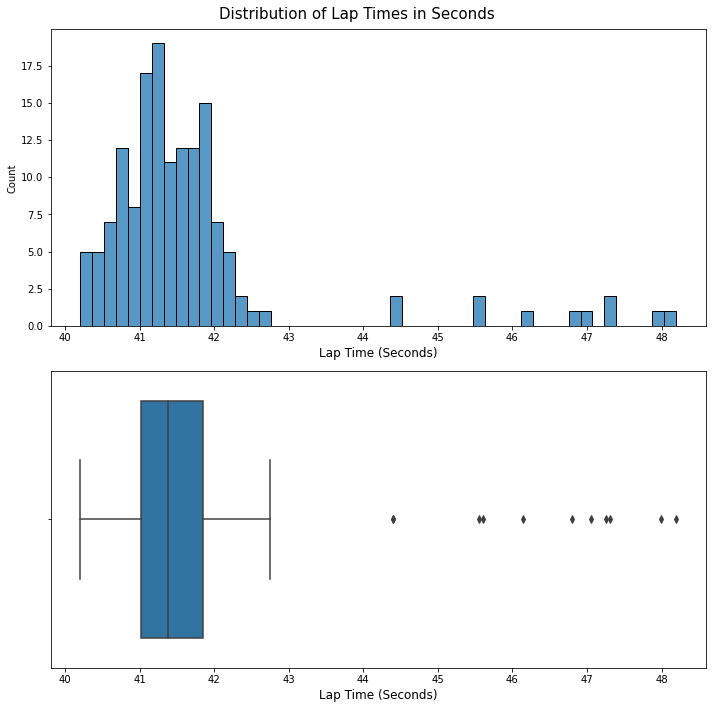

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps, bins=50, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps, ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

In [18]:
len(laps[laps['lap_time']>lap_cutoff])

11

### Add lap times to df to make sorting easier

In [19]:
df = pd.merge(left=df, right=laps['lap_time'], left_on='lap', right_index=True).copy()

### Cut laps longer than specified length

In [20]:
df = df.loc[df['lap_time'] < lap_cutoff, :].copy()
df.shape

(115052, 29)

In [21]:
# For plotting later
df.to_csv(fast_laps_save_file)

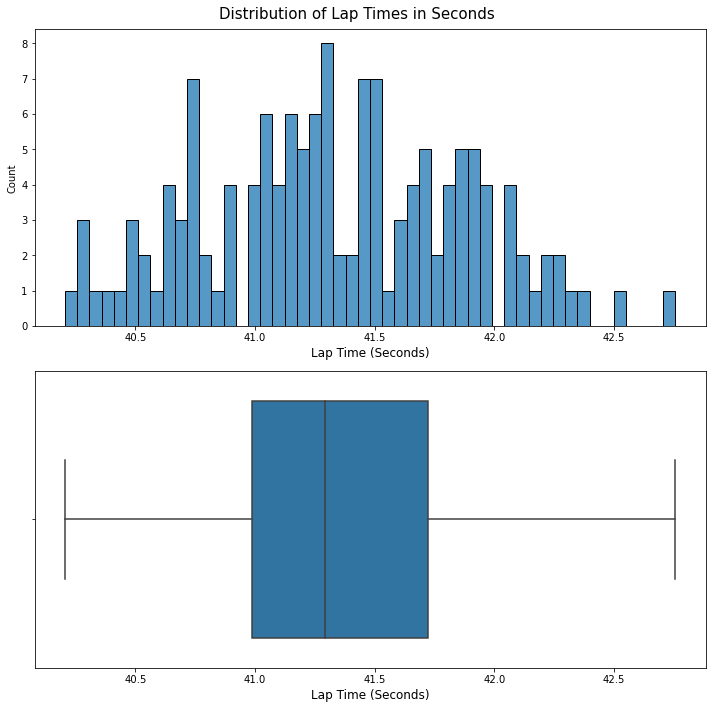

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps.loc[laps['lap_time'] < lap_cutoff], bins=50, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps.loc[laps['lap_time'] < lap_cutoff], ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

In [23]:
laps = laps.loc[laps['lap_time'] < lap_cutoff]

In [24]:
laps['lap_time'].describe()

count    139.000000
mean      41.335628
std        0.536196
min       40.206055
25%       40.985352
50%       41.291016
75%       41.723145
max       42.755127
Name: lap_time, dtype: float64

*Try cutting anything lower than 42 then train again*

In [25]:
laps.sort_values(by='lap_time').head()

,max,min,lap_time
lap,,,
110,4611.435059,4571.229004,40.206055
137,5733.276855,5692.984863,40.291992
125,5237.683105,5197.379883,40.303223
76,3182.387939,3142.083984,40.303955
132,5527.429199,5487.086914,40.342285


In [26]:
df.reset_index(drop=True, inplace=True)

### Examine IMU data

In [27]:
X_imu = df[imu_columns]
X_imu.describe()

,accel_x,accel_y,accel_z,gyro_x,gyro_y,gyro_z,vel_x,vel_y,vel_z
count,115052.000000,115052.000000,115052.000000,115052.000000,115052.000000,1.150520e+05,115052.000000,115052.000000,115052.000000
mean,0.000421,-0.001007,-0.003439,0.000018,0.001518,-2.050820e-05,-0.360510,-0.124751,12.710043
std,2.732175,1.537166,3.982663,0.001374,0.005426,1.500127e-03,0.932407,0.272192,2.414224
min,-84.802498,-12.386760,-49.931122,-0.023662,-0.032501,-1.670798e-02,-8.900988,-1.339154,4.117527
25%,-1.227975,-0.965393,-2.465367,-0.000645,-0.000733,-7.214952e-04,-0.884497,-0.384396,10.807343
50%,0.017512,-0.053339,0.443363,0.000009,0.001505,7.229557e-07,-0.277908,-0.031209,12.690360
75%,1.277843,0.881874,2.863944,0.000675,0.005762,6.992826e-04,0.039579,0.069931,14.249158
max,94.708817,53.589142,10.457180,0.015879,0.040941,3.330157e-02,5.964907,1.289006,18.467470


### Plot IMU Data

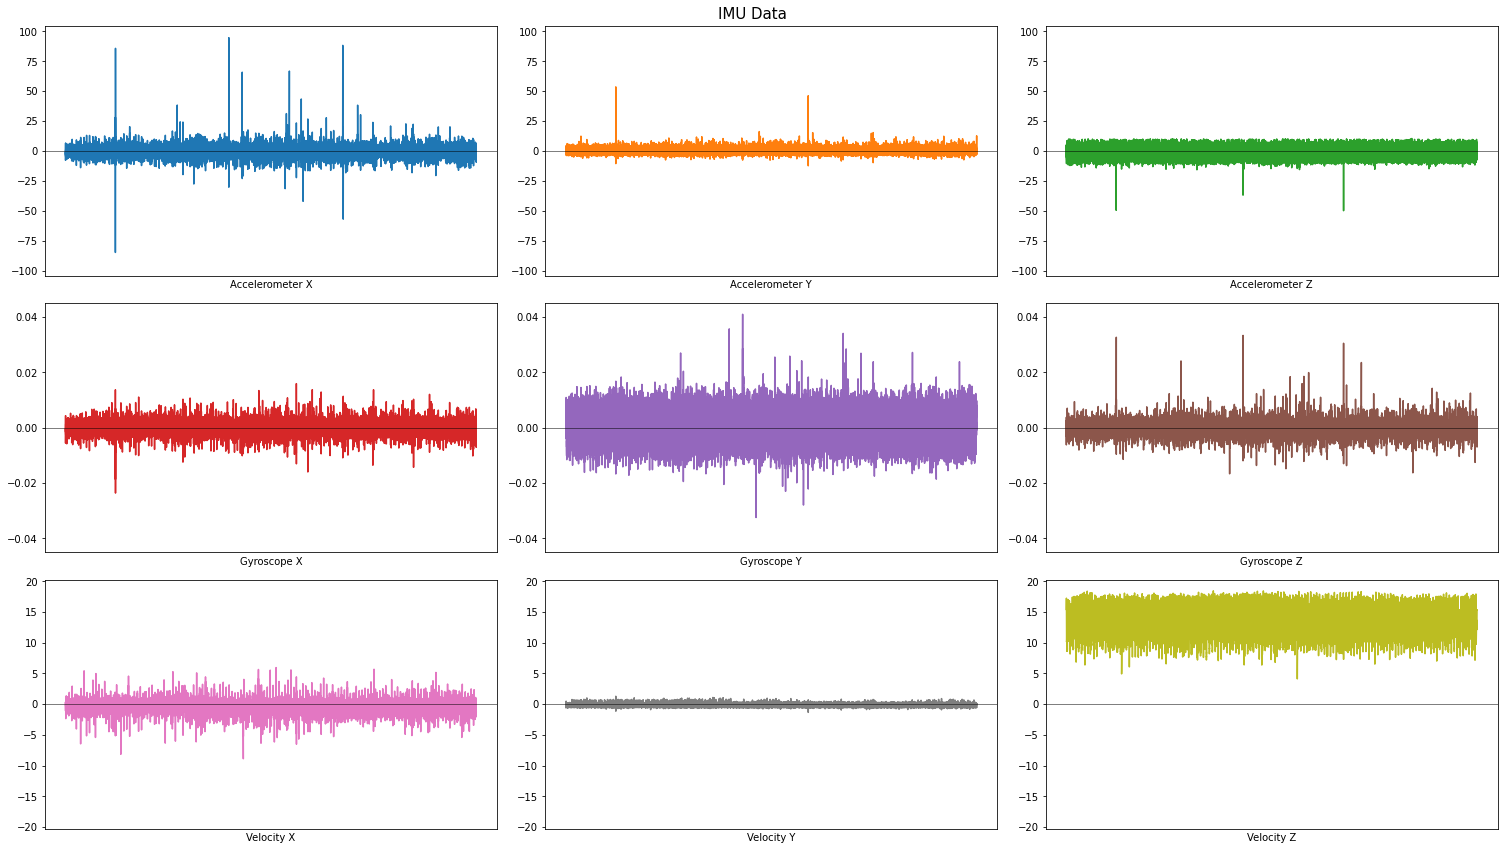

In [28]:
colors = [f'C{i}' for i in range(len(X_imu.columns))]

fig, ax = plt.subplots(3, 3, figsize=(21, 12))

fig.suptitle('IMU Data', size=15)

accel_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['accel_x', 'accel_y', 'accel_z']) * 1.1
X_imu['accel_x'].plot(ax=ax[0][0], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer X', color=colors[0])
X_imu['accel_y'].plot(ax=ax[0][1], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer Y', color=colors[1])
X_imu['accel_z'].plot(ax=ax[0][2], xticks=[], ylim=(-accel_scale, accel_scale), xlabel='Accelerometer Z', color=colors[2])

gyro_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['gyro_x', 'gyro_y', 'gyro_z']) * 1.1
X_imu['gyro_x'].plot(ax=ax[1][0], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope X', color=colors[3])
X_imu['gyro_y'].plot(ax=ax[1][1], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope Y', color=colors[4])
X_imu['gyro_z'].plot(ax=ax[1][2], xticks=[], ylim=(-gyro_scale, gyro_scale), xlabel='Gyroscope Z', color=colors[5])

vel_scale = max(max(X_imu[col].max(), abs(X_imu[col].min())) for col in ['vel_x', 'vel_y', 'vel_z']) * 1.1
X_imu['vel_x'].plot(ax=ax[2][0], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity X', color=colors[6])
X_imu['vel_y'].plot(ax=ax[2][1], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity Y', color=colors[7])
X_imu['vel_z'].plot(ax=ax[2][2], xticks=[], ylim=(-vel_scale, vel_scale), xlabel='Velocity Z', color=colors[8])

for i in range(len(ax)):
    for j in range(len(ax[0])):
        ax[i][j].axhline(y=0, color='black', linewidth=0.5)

plt.tight_layout();

*Comment*:
* IMU data was previously the only telemetry data I used. I am no longer including it in models, but I liked how these graphs looked.

### Examime Telemetry Data

In [29]:
X_telem = df[telemetry_columns]
X_telem.describe()

,speed,pitch,yaw,roll,cte,activeNode,pos_x,pos_z
count,115052.000000,115052.000000,115052.000000,115052.000000,115052.000000,115052.000000,115052.000000,115052.000000
mean,12.755837,302.482452,166.121887,103.506660,-0.100633,150.840959,-38.669048,-51.915115
std,2.398189,130.630463,102.241852,158.650070,2.366147,88.095658,40.991623,35.808975
min,4.613641,-0.005690,-0.004550,-0.005701,-5.604226,0.000000,-115.516403,-116.047401
25%,10.856855,358.079895,68.929615,2.842547,-2.181601,74.000000,-63.701173,-83.412558
50%,12.737300,358.465149,182.340599,5.933118,-0.304671,147.000000,-40.384386,-53.131336
75%,14.293335,359.784393,234.884499,353.870789,2.032558,228.000000,-10.821500,-19.690715
max,18.476959,359.994293,359.992615,359.994202,5.428277,305.000000,40.220940,15.448400


### Plot Telemetry Data

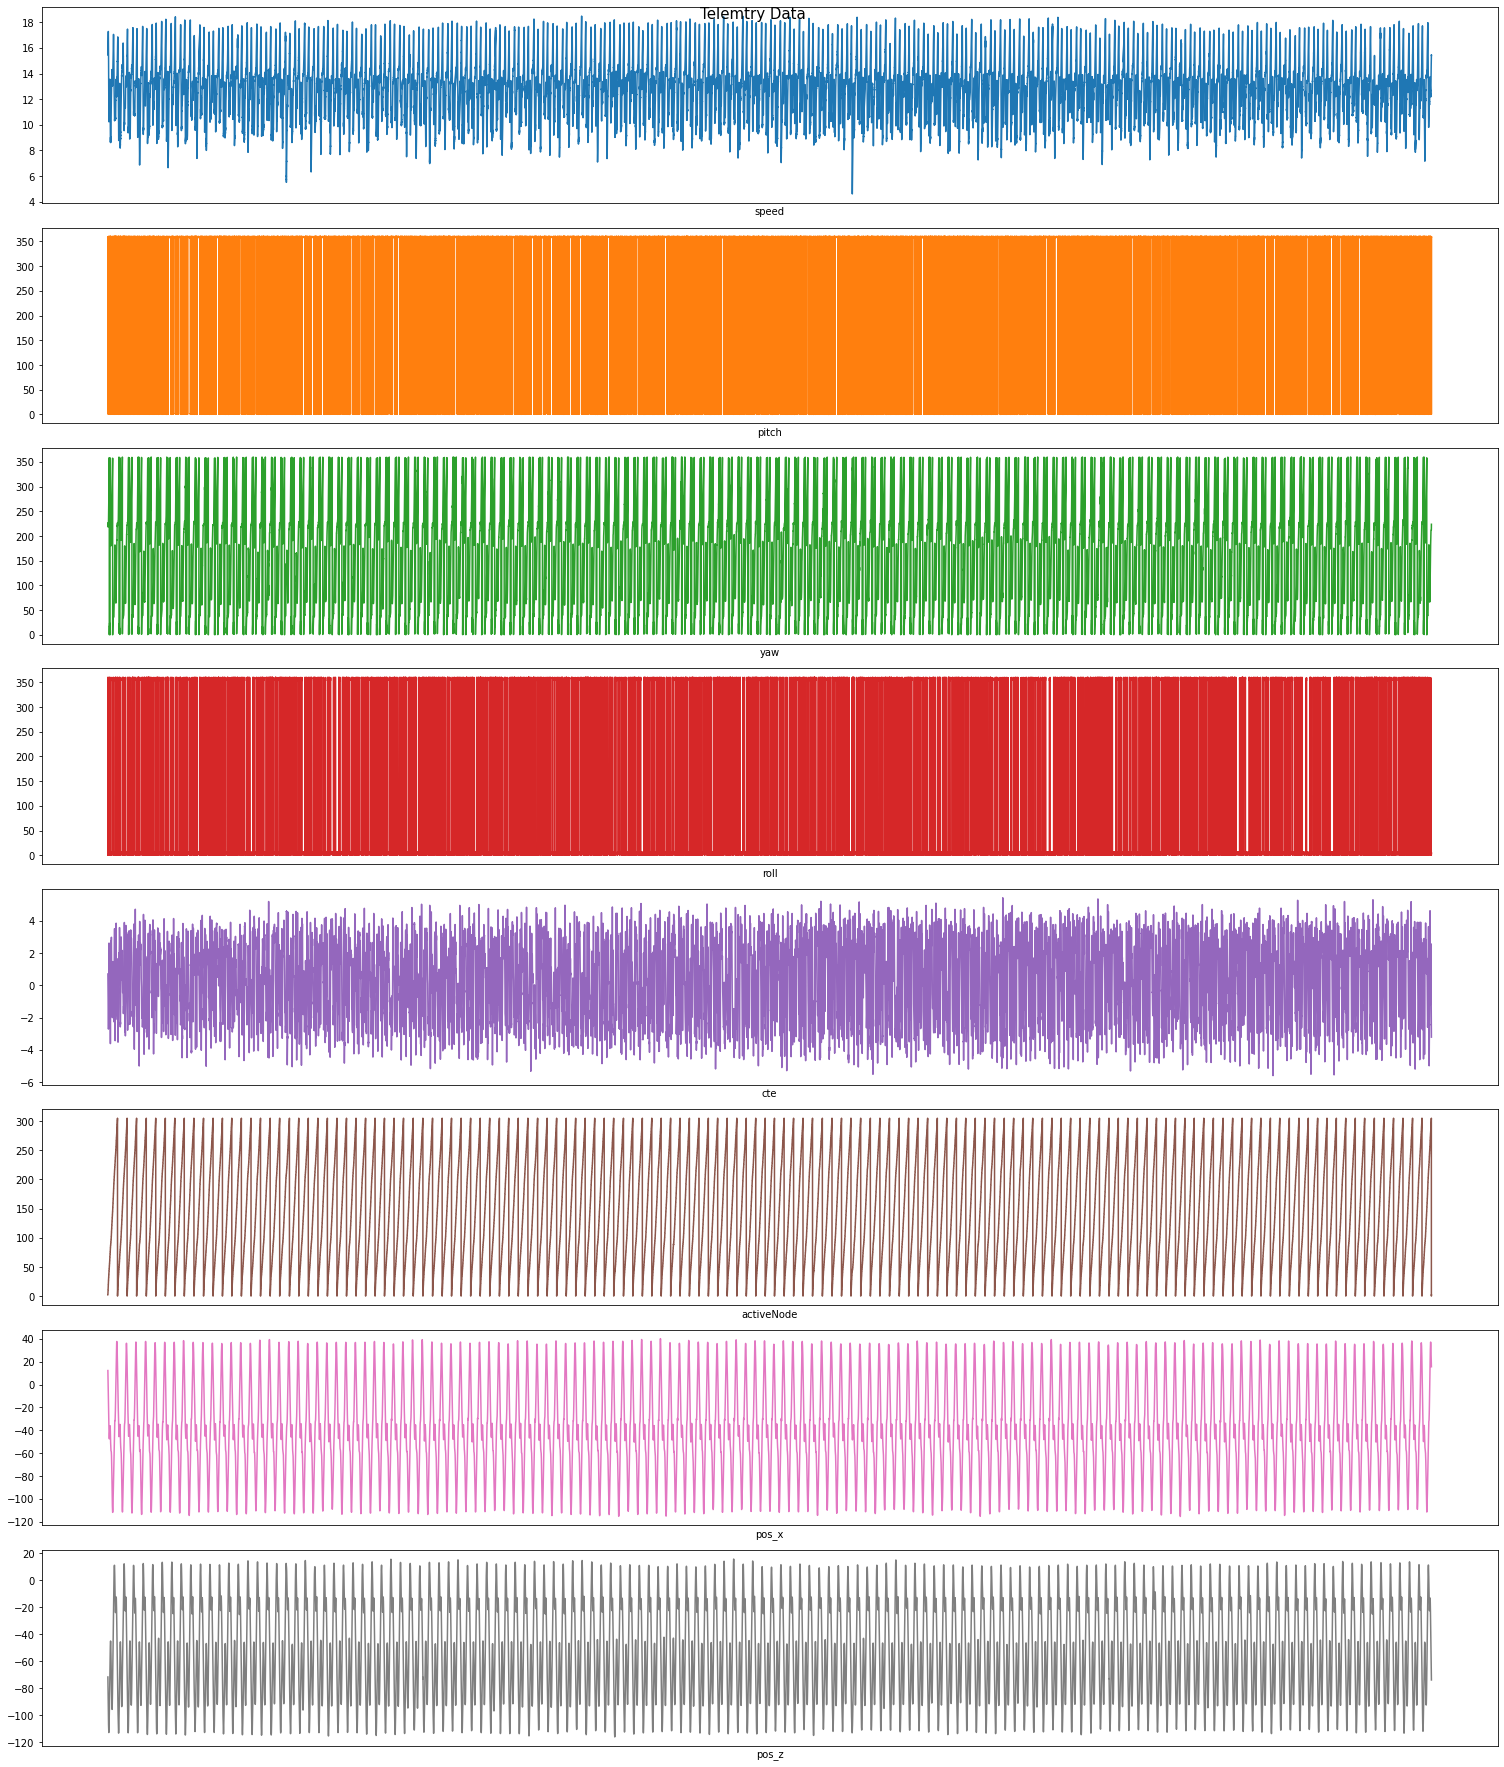

In [30]:
colors = [f'C{i}' for i in range(len(X_telem.columns))]
fig, ax = plt.subplots(len(telemetry_columns), 1, figsize=(21, len(telemetry_columns)*3 +1))
fig.suptitle('Telemtry Data', size=15)
for i in range(len(ax)):
    ax[i] = X_telem[telemetry_columns[i]].plot(ax=ax[i], xticks=[], xlabel=telemetry_columns[i], color=colors[i])
plt.tight_layout();

*Comment*:
* pitch, rollm and activeNode were included in earlier models, but I am omitting them now
* It appears that the position data make activeNode somewhat redundant

### Save Telemetry Data

In [31]:
X_telem.drop(columns=['pitch', 'roll', 'activeNode'], inplace=True)

/home/grant/anaconda3/envs/capstone/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
## Save as pickle
X_telem.to_pickle(input_telem_dataset_file)

## Image Data

In [33]:
df = df[['steering', 'throttle', 'image', ]]

### Verify Files

In [34]:
os.listdir(image_directory)[:5]

['2777.586.PNG',
 '896.3273.PNG',
 '1769.436.PNG',
 '4331.179.PNG',
 '4090.235.PNG']

### Create Image Array

In [35]:
## Using keras, load images as list, adding to a list
img_array_list = []
for img in df['image']:
    img_array_list.append(img_to_array(load_img(f"{image_directory}/{img}", 
                                                color_mode='grayscale',))) 

In [36]:
## convert list of arrays into a numpy array (of arrays())
X_img = np.array(img_array_list)

### Scale Image Data
Models expect image data in range 0 to 1.

In [37]:
X_img /= 255

## Create Datasets

### Create Targets

In [38]:
## Target: throttle and steering data
y = df.loc[:, ['steering', 'throttle']].to_numpy().copy()

## Verify size
print(f'X.shape: {X_img.shape}')
print(f'y.shape: {y.shape}')

X.shape: (115052, 64, 64, 1)
y.shape: (115052, 2)


### Save Datasets

In [39]:
## Save as binary NumPy .npy format
with open(input_image_dataset_file, 'wb') as X_out:
    np.save(file=X_out, arr=X_img)
with open(target_dataset_file, 'wb') as y_out:
    np.save(file=y_out, arr=y)